# Demand Forecasting Analysis

## Introduction
**Objective**: Analyse past 2 years of e-commerce operations data, in order to build and optimize a forecasting model for the next 4, 6 and 8 weeks, specific to:
-  Daily Order Volume
- Daily customer care tickets

## Initiation

### Import Libraries

In [600]:
# Basic imports for data analysis
from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Set pandas display options for full visibility
pd.set_option('display.max_columns', None)

# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
from utilsforecast.plotting import plot_series

# Imports for Forecasting
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, AutoARIMA
from functools import partial
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

# Imports for Forecast Evaluation
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import mae, mse, rmse, mape, smape, mase, scaled_crps

import warnings
warnings.filterwarnings('ignore')




### Import Dataset

In [2]:
# Import dataset
repo_root = Path.cwd().parent
df = pd.read_csv(repo_root / "data" / "daily_demand.csv")

In [3]:
df.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion
0,2023-01-01,613,1586,44791.35,78,1,1,0
1,2023-01-02,598,1026,50143.22,49,0,0,0
2,2023-01-03,522,1455,38737.17,61,0,0,0
3,2023-01-04,519,1287,25786.90,54,0,0,0
4,2023-01-05,609,1145,41630.79,54,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   730 non-null    object 
 1   orders                 730 non-null    int64  
 2   units_sold             730 non-null    int64  
 3   revenue                730 non-null    float64
 4   customer_care_tickets  730 non-null    int64  
 5   is_weekend             730 non-null    int64  
 6   is_holiday             730 non-null    int64  
 7   is_promotion           730 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 45.8+ KB


We don't have any NaNs in our dataset.

In [5]:
# Summary Statistics for table data
df.describe(include= 'all')

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion
count,730,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
unique,728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2024-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,926.845205,2119.484932,59922.678534,97.912329,0.286301,0.027397,0.078082
std,NaN,445.959697,1092.318130,30882.044720,56.829714,0.452342,0.163350,0.268485
min,NaN,119.000000,292.000000,8477.870000,10.000000,0.000000,0.000000,0.000000
25%,NaN,671.250000,1453.250000,41525.125000,65.000000,0.000000,0.000000,0.000000
50%,NaN,823.000000,1876.500000,53336.095000,84.000000,0.000000,0.000000,0.000000
75%,NaN,1075.750000,2479.500000,70341.242500,111.750000,1.000000,0.000000,0.000000


### Data Cleaning

#### Correction of date format

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   730 non-null    datetime64[ns]
 1   orders                 730 non-null    int64         
 2   units_sold             730 non-null    int64         
 3   revenue                730 non-null    float64       
 4   customer_care_tickets  730 non-null    int64         
 5   is_weekend             730 non-null    int64         
 6   is_holiday             730 non-null    int64         
 7   is_promotion           730 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 45.8 KB


- Other data columns are in the correct format.
- Headers are named conveniently and don't require changes.

#### Check for duplicates

In [8]:
df.duplicated().sum()

0

- No duplicate values for entire rows observed.

## Outlier Detection and Analysis

### Outlier Identification

#### IQR Approach

In [9]:
# Running a loop to create variables for 75th and 25th Percentile, based on which we derive the Inter-Quartile Range (IQR). This would thereafter be 
# used to derive upper and lower limits as classification of outliers.
cols = ["orders", "units_sold", "revenue", "customer_care_tickets"]

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    globals()[f"perc25_{col}"] = q1
    globals()[f"perc75_{col}"] = q3
    globals()[f"iqr_{col}"] = iqr
    globals()[f"upper_limit_{col}"] = q3 + 1.5 * iqr
    globals()[f"lower_limit_{col}"] = q1 - 1.5 * iqr

#### z-score Approach

In [10]:
# Generating z-scores for numerical columns
df_z = df.copy()
for c in cols:
    df_z[f"zscore_{c}"] = stats.zscore(df_z[c])

### Outlier Visualization

#### IQR Outlier visualization

In [11]:
# Create flag for outliers
df_iqr = df.copy()
df_iqr['is_outlier_orders'] = df_iqr['orders'].apply(
    lambda x: 1 if x > upper_limit_orders or x < lower_limit_orders else 0
)
df_iqr['is_outlier_units_sold'] = df_iqr['units_sold'].apply(
    lambda x: 1 if x > upper_limit_units_sold or x < lower_limit_units_sold else 0
)
df_iqr['is_outlier_revenue'] = df_iqr['revenue'].apply(
    lambda x: 1 if x > upper_limit_revenue or x < lower_limit_revenue else 0
)
df_iqr['is_outlier_customer_care_tickets'] = df_iqr['customer_care_tickets'].apply(
    lambda x: 1 if x > upper_limit_customer_care_tickets or x < lower_limit_customer_care_tickets else 0
)


In [12]:
# Quick check on order outliers
df_iqr[df_iqr['is_outlier_orders'] == 1].head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,1,1,1,1
185,2023-07-04,1720,2621,98694.02,286,0,1,0,1,0,0,1


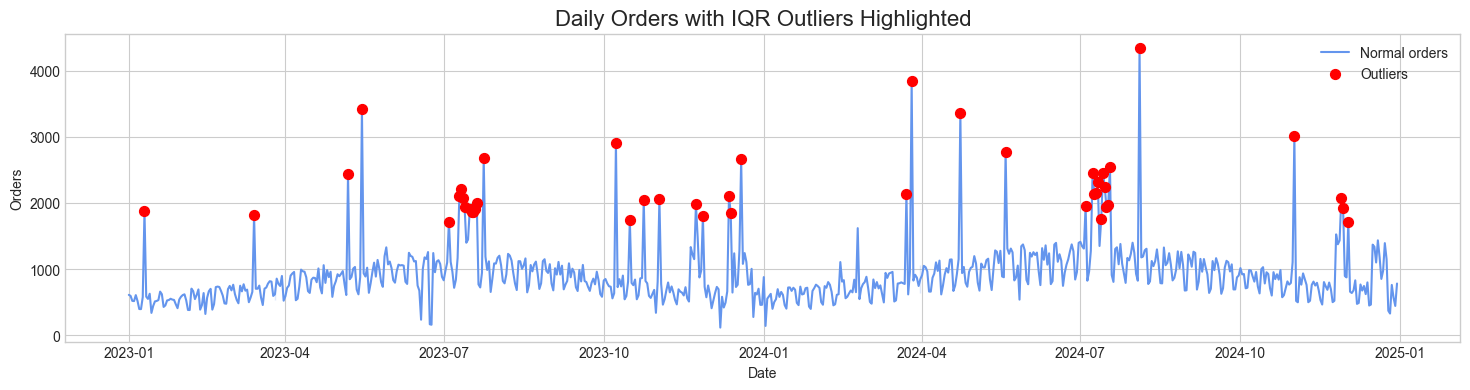

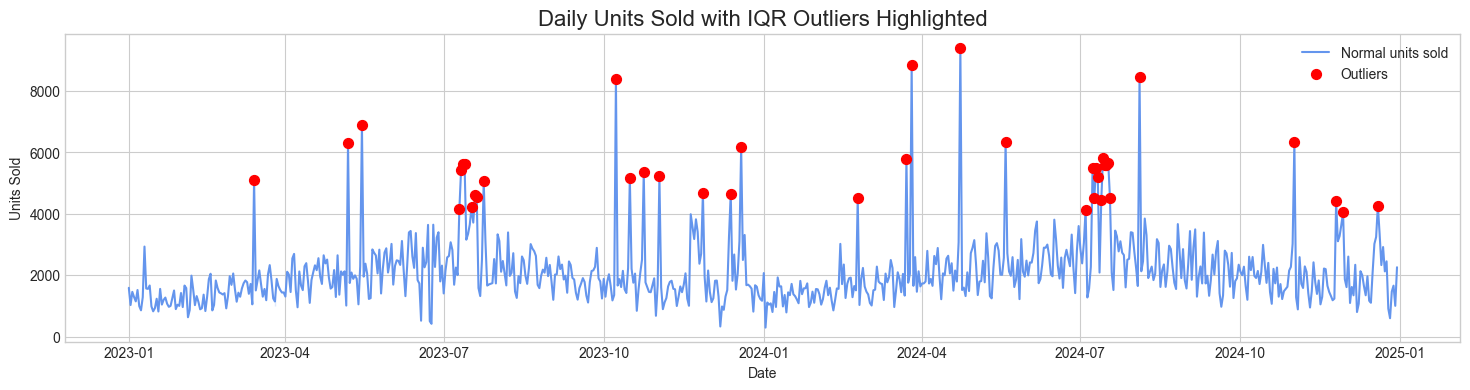

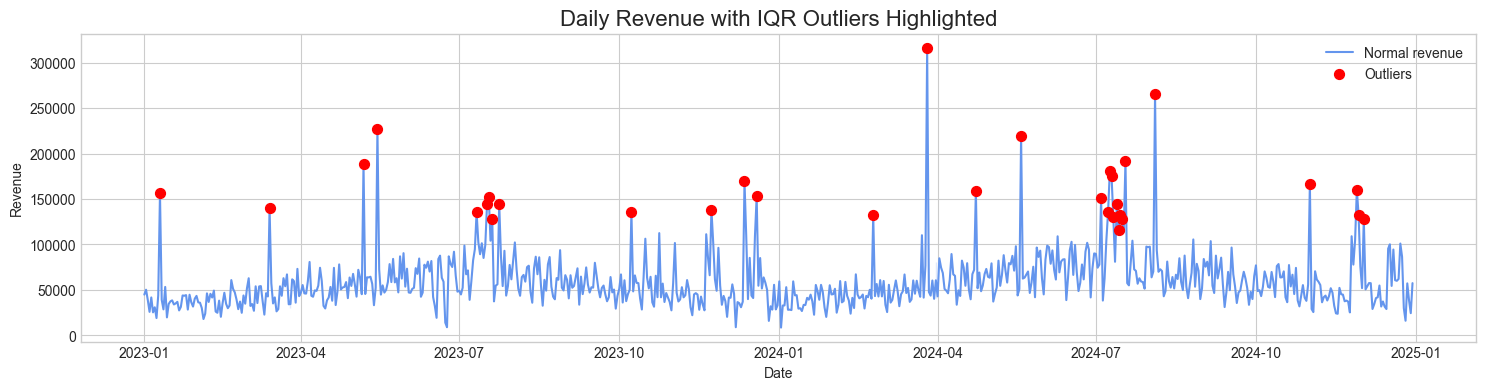

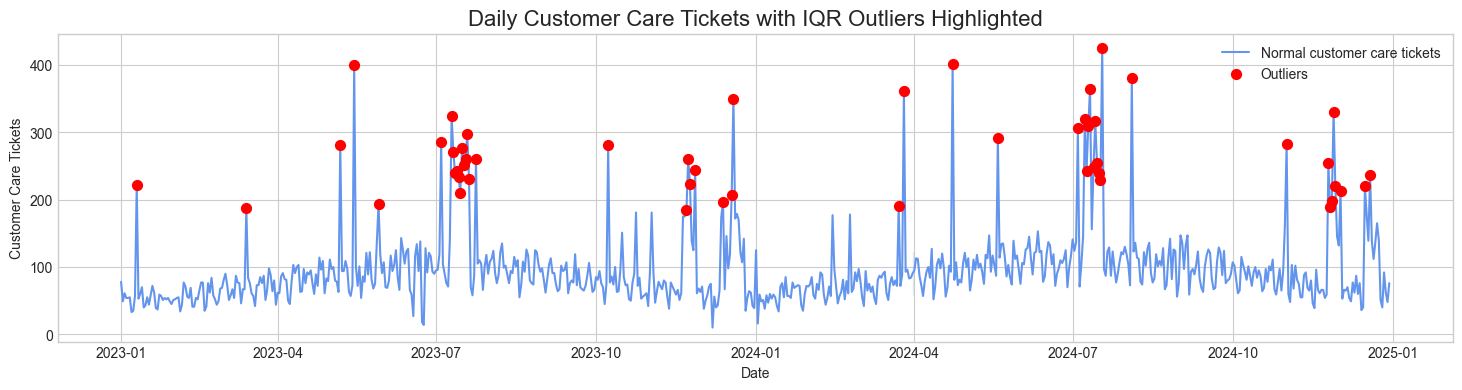

In [13]:
# Visualize IQR Outliers using Seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Loop through each column to create a plot
for column in cols:
    fig, ax = plt.subplots(figsize=(18, 4))

    # Plot the main time series line for the current column
    sns.lineplot(
        x='date', 
        y=column, 
        data=df_iqr, 
        ax=ax, 
        label=f'Normal {column.replace("_", " ")}', 
        color='cornflowerblue'
    )

    # Identify and plot the outliers for the current column
    outlier_flag_column = f'is_outlier_{column}'
    outliers_df = df_iqr[df_iqr[outlier_flag_column] == 1]
    
    ax.scatter(
        outliers_df['date'], 
        outliers_df[column], 
        color='red', 
        s=50, 
        label='Outliers',
        zorder=5  # zorder ensures points are drawn on top of the line
    )

    # Customize the plot with dynamic titles and labels 
    ax.set_title(f'Daily {column.replace("_", " ").title()} with IQR Outliers Highlighted', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{column.replace("_", " ").title()}')
    ax.legend()

    # Display the plot for the current column 
    plt.show()

#### z-score Outlier visualization

In [14]:
df_zout = df_z.copy()

for col in cols:
    zscore_column = f'zscore_{col}'
    outlier_flag_column = f'is_outlier_{col}'
    
    # Apply the lambda function to each z-score column
    df_zout[outlier_flag_column] = df_zout[zscore_column].apply(
        lambda x: 1 if (x > 3) or (x < -3) else 0
    )

# Display the first few rows to show the results
df_zout[df_zout['is_outlier_units_sold'] == 1].head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,zscore_orders,zscore_units_sold,zscore_revenue,zscore_customer_care_tickets,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
127,2023-05-07,2431,6294,188250.21,282,0,0,0,3.375162,3.824323,4.158258,3.241506,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,5.583152,4.365745,5.415567,5.319309,1,1,1,1
192,2023-07-11,2204,5431,135361.40,271,0,0,1,2.865798,3.033718,2.444477,3.047813,0,1,0,1
193,2023-07-12,2075,5617,102404.97,239,0,0,1,2.576336,3.204115,1.376574,2.484341,0,1,0,0
194,2023-07-13,1939,5607,89198.87,242,0,0,1,2.271167,3.194954,0.948650,2.537167,0,1,0,0


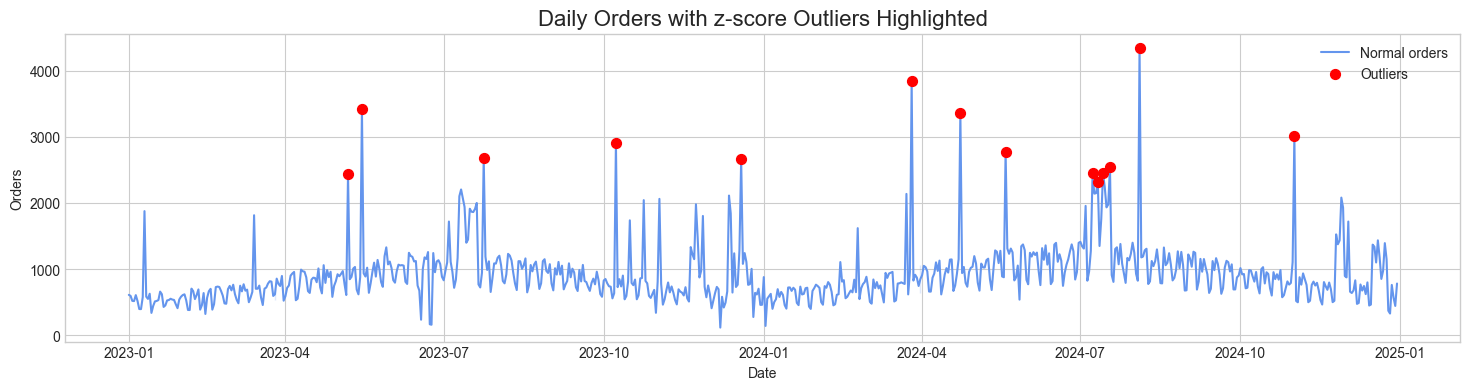

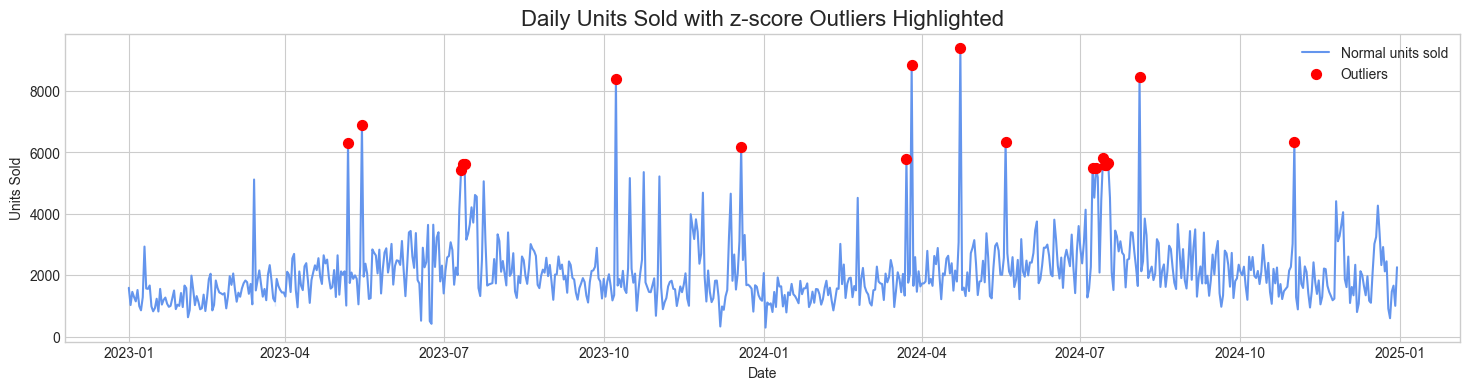

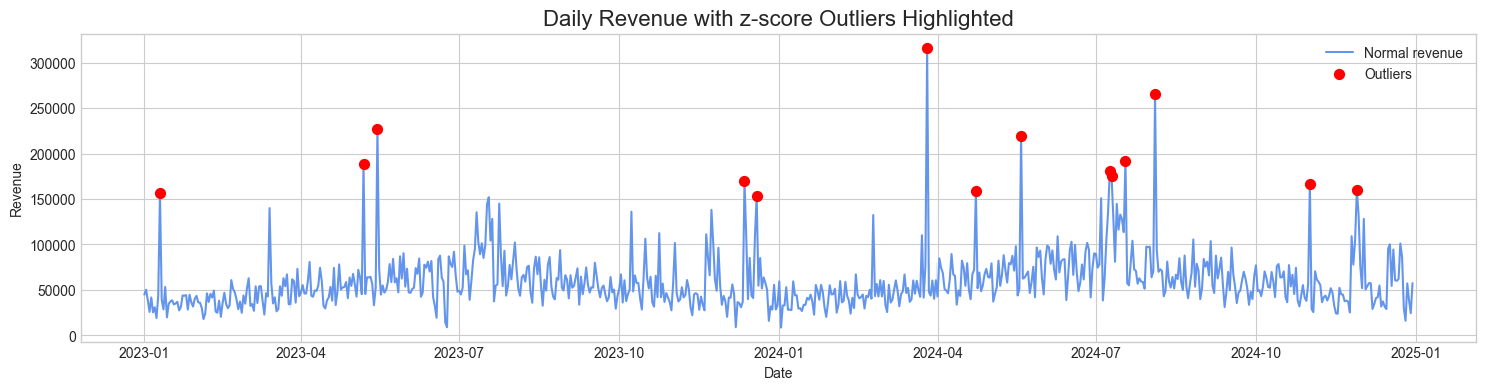

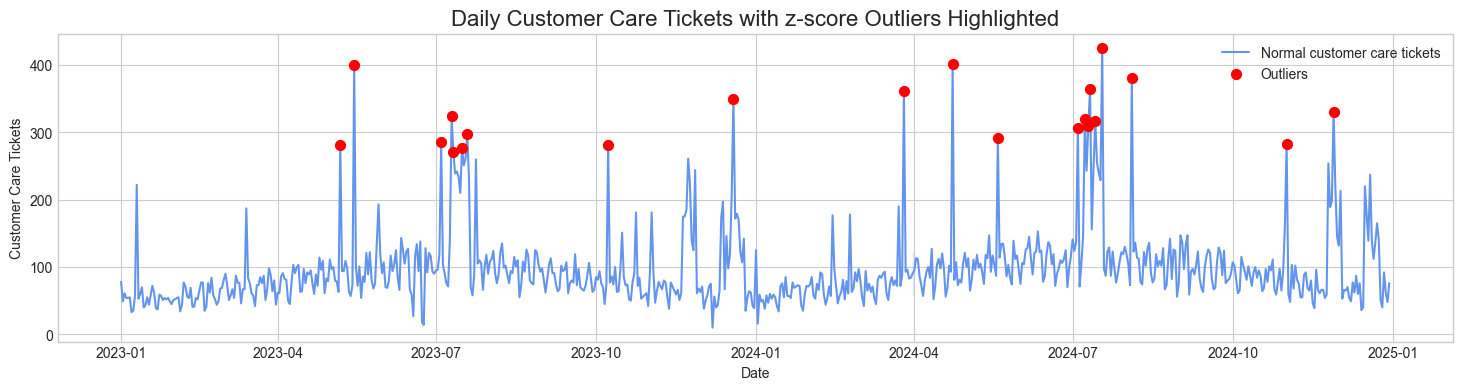

In [15]:
# Visualize z-score Outliers using Seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Loop through each column to create a plot
for column in cols:
    fig, ax = plt.subplots(figsize=(18, 4))

    # Plot the main time series line for the current column
    sns.lineplot(
        x='date', 
        y=column, 
        data=df_zout, 
        ax=ax, 
        label=f'Normal {column.replace("_", " ")}', 
        color='cornflowerblue'
    )

    # Identify and plot the outliers for the current column
    outlier_flag_column = f'is_outlier_{column}'
    outliers_df = df_zout[df_zout[outlier_flag_column] == 1]
    
    ax.scatter(
        outliers_df['date'], 
        outliers_df[column], 
        color='red', 
        s=50, 
        label='Outliers',
        zorder=5  # zorder ensures points are drawn on top of the line
    )

    # Customize the plot with dynamic titles and labels 
    ax.set_title(f'Daily {column.replace("_", " ").title()} with z-score Outliers Highlighted', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{column.replace("_", " ").title()}')
    ax.legend()

    # Display the plot for the current column 
    plt.show()

### Observation Summary (Handling of Outliers)

- Based on the visualizations from IQR and z-score approach, we generally observe fewer outliers using the z-score approach.  
- We will check for the distribution of order values to see if we have a close to normal distribution. 

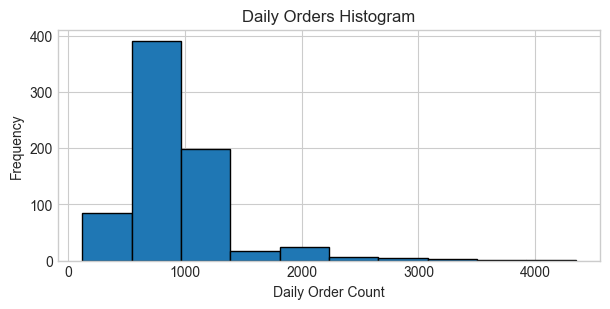

In [16]:
# Plot a histogram of orders
plt.figure(figsize= (7,3))
df['orders'].hist(edgecolor= 'black')
plt.xlabel('Daily Order Count')
plt.ylabel('Frequency')
plt.title('Daily Orders Histogram')
plt.show()

The distribution of orders seems skewed to the right, in which case, z-score approach wouldn't be effective in identifying outliers. We'll use the outliers identified using IQR approach going forward.

As the forecast is meant for orders and customer tickets, we'll look into the outlier values of orders, generally customer tickets follow a similar trend.

#### Promo Analysis

In [17]:
# Filter out promo period data 
promo_review =  df_iqr[df_iqr['is_promotion'] == 1].copy()
promo_review['year'] = promo_review['date'].dt.year
promo_review.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,year
191,2023-07-10,2102,4139,94656.93,324,0,0,1,1,1,0,1,2023
192,2023-07-11,2204,5431,135361.40,271,0,0,1,1,1,1,1,2023
193,2023-07-12,2075,5617,102404.97,239,0,0,1,1,1,0,1,2023
194,2023-07-13,1939,5607,89198.87,242,0,0,1,1,1,0,1,2023
195,2023-07-14,1400,3154,101250.77,234,1,0,1,0,0,0,1,2023


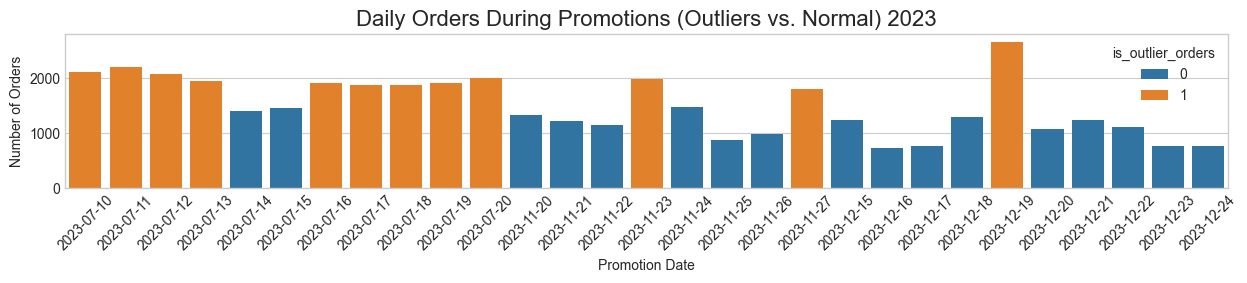

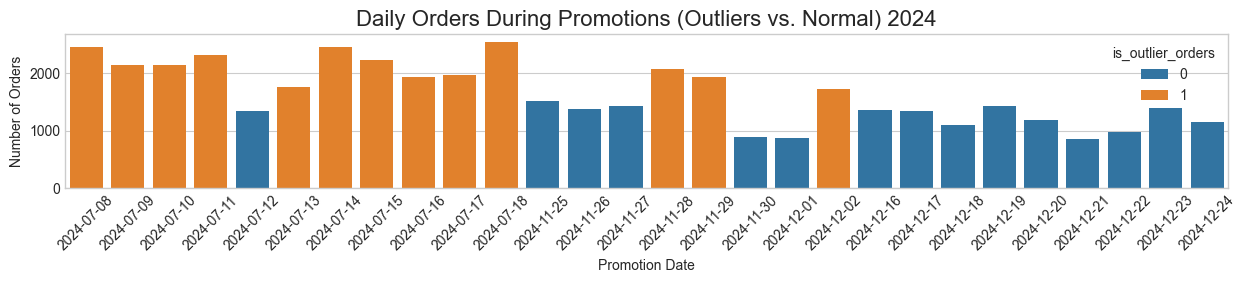

In [18]:
# Plot 2023 and 2024 promo daily orders highlighting outlier values
plt.figure(figsize= (15,2))
sns.barplot(data= promo_review[promo_review['year'] == 2023], 
            x= 'date', 
            y= 'orders', 
            hue= 'is_outlier_orders')

plt.title('Daily Orders During Promotions (Outliers vs. Normal) 2023', fontsize=16)
plt.xlabel('Promotion Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize= (15,2))
sns.barplot(data= promo_review[promo_review['year'] == 2024], 
            x= 'date', 
            y= 'orders', 
            hue= 'is_outlier_orders')

plt.title('Daily Orders During Promotions (Outliers vs. Normal) 2024', fontsize=16)
plt.xlabel('Promotion Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation = 45)
plt.show()

- We observe that July, November and December are the promo months, wherein we have the max. daily order outliers in July.
- We have 11 days of July Promo in both 2023 and 2024, however, the date are slightly offset. From 2023 to 2024, daily orders during the promo period has seen an increase. We will refer to this as *Summer Sale* going forward.
- We have 8 days of promo towards the end of November, in both 2023 and 2024, which might be the *Black Friday Sale*. Generally the daily order performance seems to be lower than Summer Sale.
- We have 9-10 days of promo before Christmas, which we can refer to as *December Sale* going forward. Generally the performance seems lower compared to other promos.

In [19]:
# Check start day of Summer Sale
print('Summer Sale')
print('2023-07-10 Day:',promo_review[promo_review['date'] == '2023-07-10']['date'].dt.day_name())
print('2024-07-08 Day:',promo_review[promo_review['date'] == '2024-07-08']['date'].dt.day_name())

print()

print('Black Friday Sale')
print('2023-11-20 Day:',promo_review[promo_review['date'] == '2023-11-20']['date'].dt.day_name())
print('2024-11-25 Day:',promo_review[promo_review['date'] == '2024-11-25']['date'].dt.day_name())

print()

print('December Sale')
print('2023-12-15 Day:',promo_review[promo_review['date'] == '2023-12-15']['date'].dt.day_name())
print('2024-12-16 Day:',promo_review[promo_review['date'] == '2024-12-16']['date'].dt.day_name())

Summer Sale
2023-07-10 Day: 191    Monday
Name: date, dtype: object
2024-07-08 Day: 555    Monday
Name: date, dtype: object

Black Friday Sale
2023-11-20 Day: 323    Monday
Name: date, dtype: object
2024-11-25 Day: 694    Monday
Name: date, dtype: object

December Sale
2023-12-15 Day: 348    Friday
Name: date, dtype: object
2024-12-16 Day: 715    Monday
Name: date, dtype: object


- We see that the Summer Sale and Black Friday Sale starts from Monday each year.
- December Sale might not necesarily have  Monday start.

- Promo usually ends on Thursday in the second week. The daily orders usually ends on a high note.

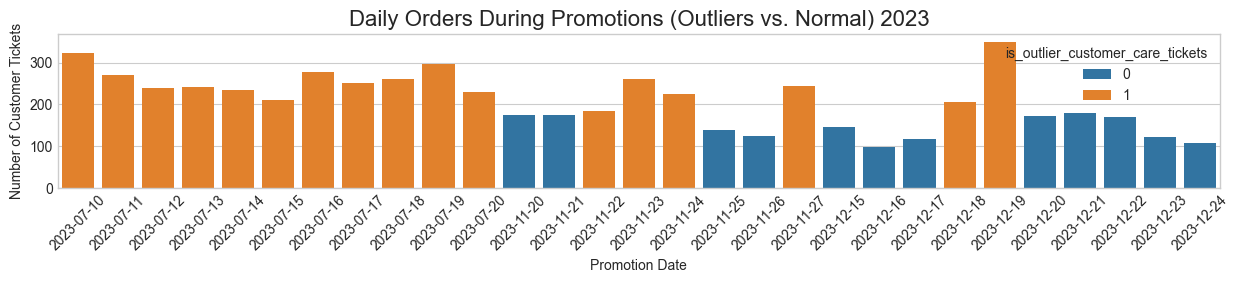

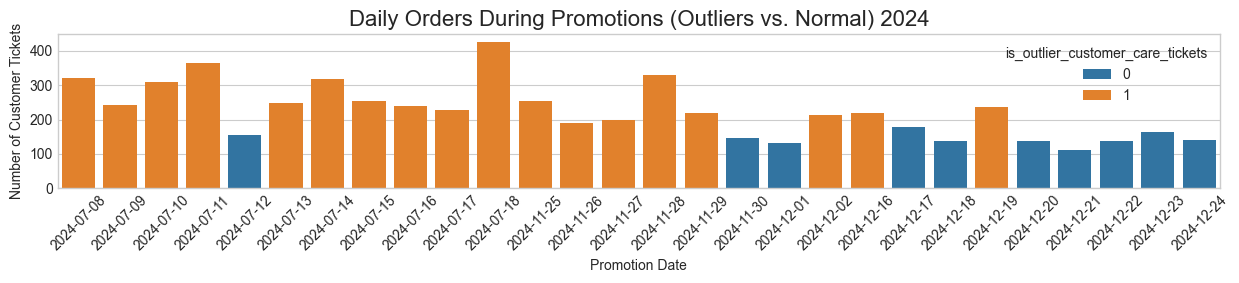

In [20]:
# Plot 2023 and 2024 promo daily customer tickets highlighting outlier values
plt.figure(figsize= (15,2))
sns.barplot(data= promo_review[promo_review['year'] == 2023], 
            x= 'date', 
            y= 'customer_care_tickets', 
            hue= 'is_outlier_customer_care_tickets')

plt.title('Daily Orders During Promotions (Outliers vs. Normal) 2023', fontsize=16)
plt.xlabel('Promotion Date')
plt.ylabel('Number of Customer Tickets')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize= (15,2))
sns.barplot(data= promo_review[promo_review['year'] == 2024], 
            x= 'date', 
            y= 'customer_care_tickets', 
            hue= 'is_outlier_customer_care_tickets')

plt.title('Daily Orders During Promotions (Outliers vs. Normal) 2024', fontsize=16)
plt.xlabel('Promotion Date')
plt.ylabel('Number of Customer Tickets')
plt.xticks(rotation = 45)
plt.show()

- Generally, for most of the promo days, we observe a very high daily customer care tickets, with there being significantoutliers in 2024 vs. 2023.

*As the outliers within promo periods can be explained based on increase in orders, we will not make any alterations here, and would explain these to the model using the promo flag feature ('is_promotion').*

#### Holiday Analysis

In [21]:
# Filter out holiday data 
holiday_review = df_iqr[df_iqr['is_holiday'] ==1].copy()
holiday_review['year'] = holiday_review['date'].dt.year
holiday_review.head()


,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,year
0,2023-01-01,613,1586,44791.35,78,1,1,0,0,0,0,0,2023
44,2023-02-14,325,831,20350.27,52,0,1,0,0,0,0,0,2023
149,2023-05-29,1330,2873,62421.03,193,0,1,0,0,0,0,1,2023
185,2023-07-04,1720,2621,98694.02,286,0,1,0,1,0,0,1,2023
303,2023-10-31,342,676,27457.33,42,0,1,0,0,0,0,0,2023


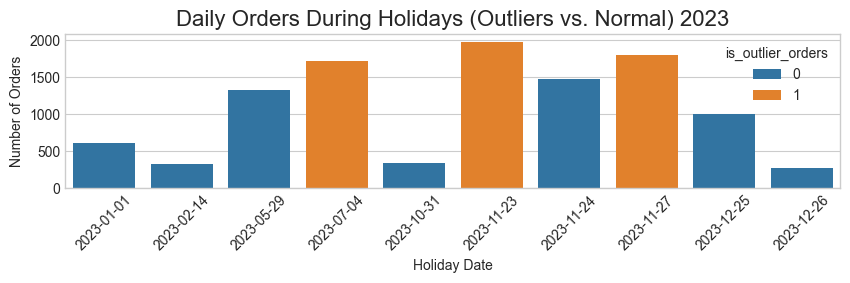

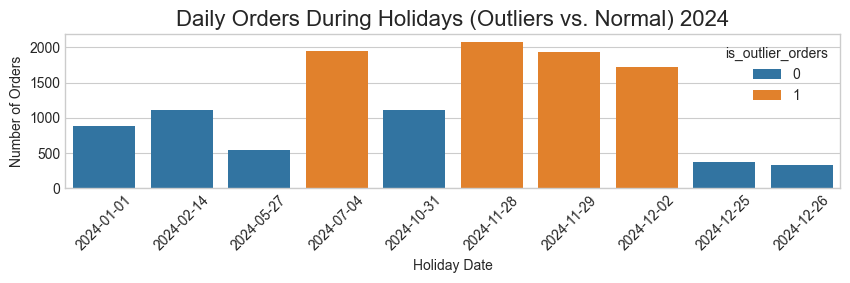

In [22]:
# Plot 2023 and 2024 holiday daily orders highlighting outlier values
plt.figure(figsize= (10,2))
sns.barplot(data= holiday_review[holiday_review['year'] == 2023], 
            x= 'date', 
            y= 'orders', 
            hue= 'is_outlier_orders')

plt.title('Daily Orders During Holidays (Outliers vs. Normal) 2023', fontsize=16)
plt.xlabel('Holiday Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize= (10,2))
sns.barplot(data= holiday_review[holiday_review['year'] == 2024], 
            x= 'date', 
            y= 'orders', 
            hue= 'is_outlier_orders')

plt.title('Daily Orders During Holidays (Outliers vs. Normal) 2024', fontsize=16)
plt.xlabel('Holiday Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation = 45)
plt.show()

*Observations:*
- 4th July is the Independance Day in U.S. and can attract a lot of customers. Probably, this causes a spike in orders for both 2023 and 2024.
- 23rd Nov. 2023 and 28th Nov. 2024 were **Thanksgiving Day**, which generally attract a lot of customers. Around the same time, we also have the Black Friday Sale and Cyber Week, which would boost the orders during this period.
- The other holiday periods do not show up as outliers in terms of daily orders.

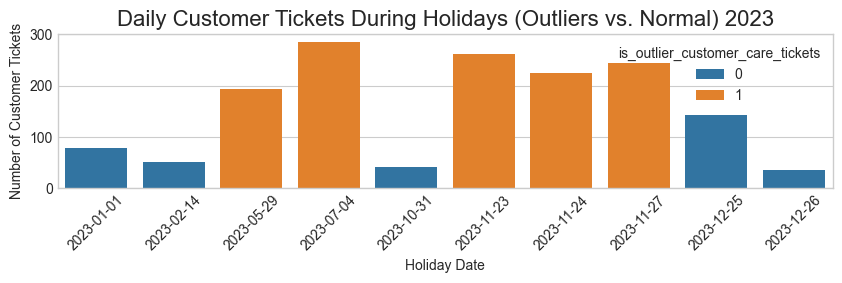

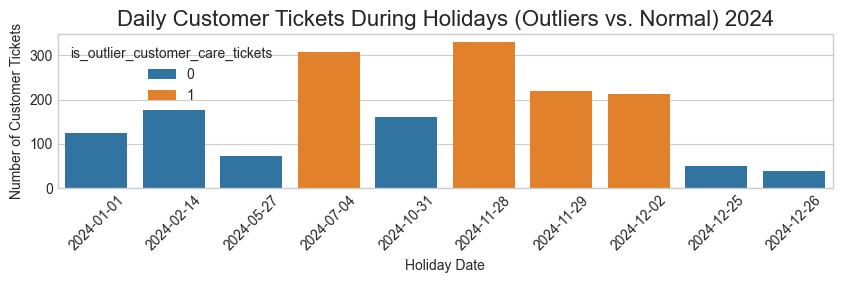

In [23]:
# Plot 2023 and 2024 holiday customer tickets highlighting outlier values
plt.figure(figsize= (10,2))
sns.barplot(data= holiday_review[holiday_review['year'] == 2023], 
            x= 'date', 
            y= 'customer_care_tickets', 
            hue= 'is_outlier_customer_care_tickets')

plt.title('Daily Customer Tickets During Holidays (Outliers vs. Normal) 2023', fontsize=16)
plt.xlabel('Holiday Date')
plt.ylabel('Number of Customer Tickets')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize= (10,2))
sns.barplot(data= holiday_review[holiday_review['year'] == 2024], 
            x= 'date', 
            y= 'customer_care_tickets', 
            hue= 'is_outlier_customer_care_tickets')

plt.title('Daily Customer Tickets During Holidays (Outliers vs. Normal) 2024', fontsize=16)
plt.xlabel('Holiday Date')
plt.ylabel('Number of Customer Tickets')
plt.xticks(rotation = 45)
plt.show()

*Observations:*
- Customer Ticket Outliers follows a similar trend as daily orders.
- 2023 and 2024 shows a similar trend, however, we see an unusual spike on 29th May 2023, which might be for Memorial Day, if it's the U.S. market. Though the orders on this holiday wasn't an outlier, it seems the daily customer ticket is. 

*As the outliers within holiday periods can be explained based on increase in orders, we will not make any alterations here, and would explain these to the model using the holiday flag feature ('is_holiday').*

#### Weekend Analysis

In [24]:
# Calculate mean daily orders for weekdays vs. weekends
df_iqr.groupby(['is_weekend'])[['orders']].mean().round(2)

,orders
is_weekend,
0,1029.06
1,672.05


In [25]:
# Calculate mean daily customer tickets for weekdays vs. weekends
df_iqr.groupby(['is_weekend'])[['customer_care_tickets']].mean().round(2)

,customer_care_tickets
is_weekend,
0,109.11
1,70.00


As we see that we have a lower orders and ticket counts on weekends than on weekdays, this factor wouldn't explain positive outliers.

#### Leftover Outliers

In [26]:
order_outlier_df = df_iqr[(df_iqr['is_holiday'] == 0) & (df_iqr['is_promotion'] == 0) & (df_iqr['is_outlier_orders'] == 1)].copy()
order_outlier_df.shape

(17, 12)

In [27]:
order_outlier_df.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,1,1,1,1
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1


We have 17 orders which are outliers and are not explained by holiday or promo period. We will look into these further as part of feature engineering to see if there is an explanation, else would be handled appropriately at data preparation stage.

In [28]:
ticket_outlier_df = df_iqr[(df_iqr['is_holiday'] == 0) & (df_iqr['is_promotion'] == 0) & (df_iqr['is_outlier_customer_care_tickets'] == 1)].copy()
ticket_outlier_df.shape

(13, 12)

In [29]:
ticket_outlier_df.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,1,1,1,1
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1


We have 13 records, wherein the daily tickets is an outlier and isn't explained by holidays or promos. We will look into these further as part of feature engineering to see if there is an explanation, else would be handled appropriately at data preparation stage.

## Feature Engineering

### Outlier Manipulation

As we target orders and customer tickets for forecast, we'll be cleaning up unexplained outliers particularly for these variables.  
We'll impute the upper limit values for orders and customer tickets respectively:
- Imputed Value = Q3 + (1.5 * IQR) = Upper Limit

In [30]:
# Filter unexplained outliers 
unexplained_outlier_cond_orders = (df_iqr['is_outlier_orders'] == 1) & (df_iqr['is_promotion'] == 0) & (df_iqr['is_holiday'] == 0) & (df_iqr['is_weekend'] == 0)
df_iqr[unexplained_outlier_cond_orders]

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,1,1,1,1
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1
281,2023-10-08,2904,8374,135972.45,281,0,0,0,1,1,1,1
289,2023-10-16,1738,5159,106253.18,151,0,0,0,1,1,0,0
297,2023-10-24,2043,5353,112425.45,181,0,0,0,1,1,0,0
305,2023-11-02,2062,5213,101546.04,181,0,0,0,1,1,0,0
345,2023-12-12,2112,3252,169278.72,174,0,0,0,1,0,1,0


- One of the noticeable feature here is that quite a few of the spikes are close to the mid of the month, which might be due to 'Payday Effect'. It would be helpful to position the days relatively within the month as a feature.

In [31]:
# Define function to categorize date as start/mid of month if applicable
def get_payday_effect(date):
    if date.day >= 15 and date.day <= 20:
        return 1
    else:
        return 0

In [32]:
# df_iqr = df_iqr.drop(['payday_period'], axis= 1)
df_iqr['payday_period'] = df_iqr['date'].apply(get_payday_effect)
df_iqr.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,payday_period
0,2023-01-01,613,1586,44791.35,78,1,1,0,0,0,0,0,0
1,2023-01-02,598,1026,50143.22,49,0,0,0,0,0,0,0,0
2,2023-01-03,522,1455,38737.17,61,0,0,0,0,0,0,0,0
3,2023-01-04,519,1287,25786.90,54,0,0,0,0,0,0,0,0
4,2023-01-05,609,1145,41630.79,54,0,0,0,0,0,0,0,0


In [33]:
df_iqr.groupby('payday_period')[['orders']].mean()

,orders
payday_period,
0,916.414676
1,969.291667


We generally observe a higher mean daily order count towards the mid of the month. We'll remove these from our set of unexplained outliers

In [34]:
unexplained_outlier_cond_orders = (df_iqr['is_outlier_orders'] == 1) & (df_iqr['is_promotion'] == 0) & (df_iqr['is_holiday'] == 0) & (df_iqr['is_weekend'] == 0) & (df_iqr['payday_period'] == 0)
df_iqr[unexplained_outlier_cond_orders].head()


,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,payday_period
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1,0
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1,0
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1,0
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1,0
281,2023-10-08,2904,8374,135972.45,281,0,0,0,1,1,1,1,0


- We notice, predominantly in 2024, that eventhough it's not an outlier, there is a surge in orders right before Christmas, which could be the Christmas Shopping Season. We will highlight this as a feature likely to impact the orders.

In [35]:
df_iqr[unexplained_outlier_cond_orders].shape

(13, 13)

We are left with 13 outliers for which we'll impute values as mentioned earlier.

In [ ]:
upper_limit_orders # Upper Limit value for orders

1682.5

In [36]:
# Replace outlier values with upper limit for orders
df_iqr['orders_cleaned'] = np.where(
    unexplained_outlier_cond_orders,  
    upper_limit_orders,                 
    df_iqr['orders'])                    

In [39]:
df_iqr[unexplained_outlier_cond_orders]

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,payday_period,orders_cleaned
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1,0,1682.5
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1,0,1682.5
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1,0,1682.5
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1,0,1682.5
281,2023-10-08,2904,8374,135972.45,281,0,0,0,1,1,1,1,0,1682.5
297,2023-10-24,2043,5353,112425.45,181,0,0,0,1,1,0,0,0,1682.5
305,2023-11-02,2062,5213,101546.04,181,0,0,0,1,1,0,0,0,1682.5
345,2023-12-12,2112,3252,169278.72,174,0,0,0,1,0,1,0,0,1682.5
346,2023-12-13,1843,4651,109223.32,197,0,0,0,1,1,0,1,0,1682.5
450,2024-03-26,3844,8826,316556.50,361,0,0,0,1,1,1,1,0,1682.5


In [42]:
unexplained_outlier_cond_tickets = (df_iqr['is_outlier_customer_care_tickets'] == 1) & (df_iqr['is_weekend'] == 0) & (df_iqr['is_holiday'] == 0) & (df_iqr['is_promotion'] == 0) & (df_iqr['payday_period'] == 0)
df_iqr[unexplained_outlier_cond_tickets].shape

(10, 14)

We have 10 unexplained outliers for customer tickets. 

In [43]:
df_iqr[unexplained_outlier_cond_tickets]

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,payday_period,orders_cleaned
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1,0,1682.5
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1,0,1682.5
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1,0,1682.5
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1,0,1682.5
281,2023-10-08,2904,8374,135972.45,281,0,0,0,1,1,1,1,0,1682.5
346,2023-12-13,1843,4651,109223.32,197,0,0,0,1,1,0,1,0,1682.5
450,2024-03-26,3844,8826,316556.50,361,0,0,0,1,1,1,1,0,1682.5
479,2024-04-23,3359,9407,159065.64,401,0,0,0,1,1,1,1,0,1682.5
582,2024-08-04,4346,8465,265554.09,381,0,0,0,1,1,1,1,0,1682.5
670,2024-11-01,3014,6323,166789.98,283,0,0,0,1,1,1,1,0,1682.5


We'll follow a similar approach to impute the upper limit values.

In [ ]:
upper_limit_customer_care_tickets # Upper limit for customer care tickets

181.875

In [44]:
# Replace outlier values with upper limit for customer tickets
df_iqr['customer_care_tickets_cleaned'] = np.where(
    unexplained_outlier_cond_tickets,  
    upper_limit_customer_care_tickets,                 
    df_iqr['customer_care_tickets'])  

df_iqr[unexplained_outlier_cond_tickets].head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets,payday_period,orders_cleaned,customer_care_tickets_cleaned
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1,0,1682.5,181.875
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1,0,1682.5,181.875
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1,0,1682.5,181.875
205,2023-07-24,2673,5054,144922.17,260,0,0,0,1,1,1,1,0,1682.5,181.875
281,2023-10-08,2904,8374,135972.45,281,0,0,0,1,1,1,1,0,1682.5,181.875


### Correlation Analysis

In [456]:
# Creating a new DF to be used for model build

# Remove outlier flag columns, existing orders and customer tickets column

data_build1= df_iqr.drop(['orders','customer_care_tickets','is_outlier_orders','is_outlier_units_sold','is_outlier_revenue','is_outlier_customer_care_tickets'], axis= 1).copy()
data_build1.head()

,date,units_sold,revenue,is_weekend,is_holiday,is_promotion,payday_period,orders_cleaned,customer_care_tickets_cleaned
0,2023-01-01,1586,44791.35,1,1,0,0,613.0,78.0
1,2023-01-02,1026,50143.22,0,0,0,0,598.0,49.0
2,2023-01-03,1455,38737.17,0,0,0,0,522.0,61.0
3,2023-01-04,1287,25786.90,0,0,0,0,519.0,54.0
4,2023-01-05,1145,41630.79,0,0,0,0,609.0,54.0


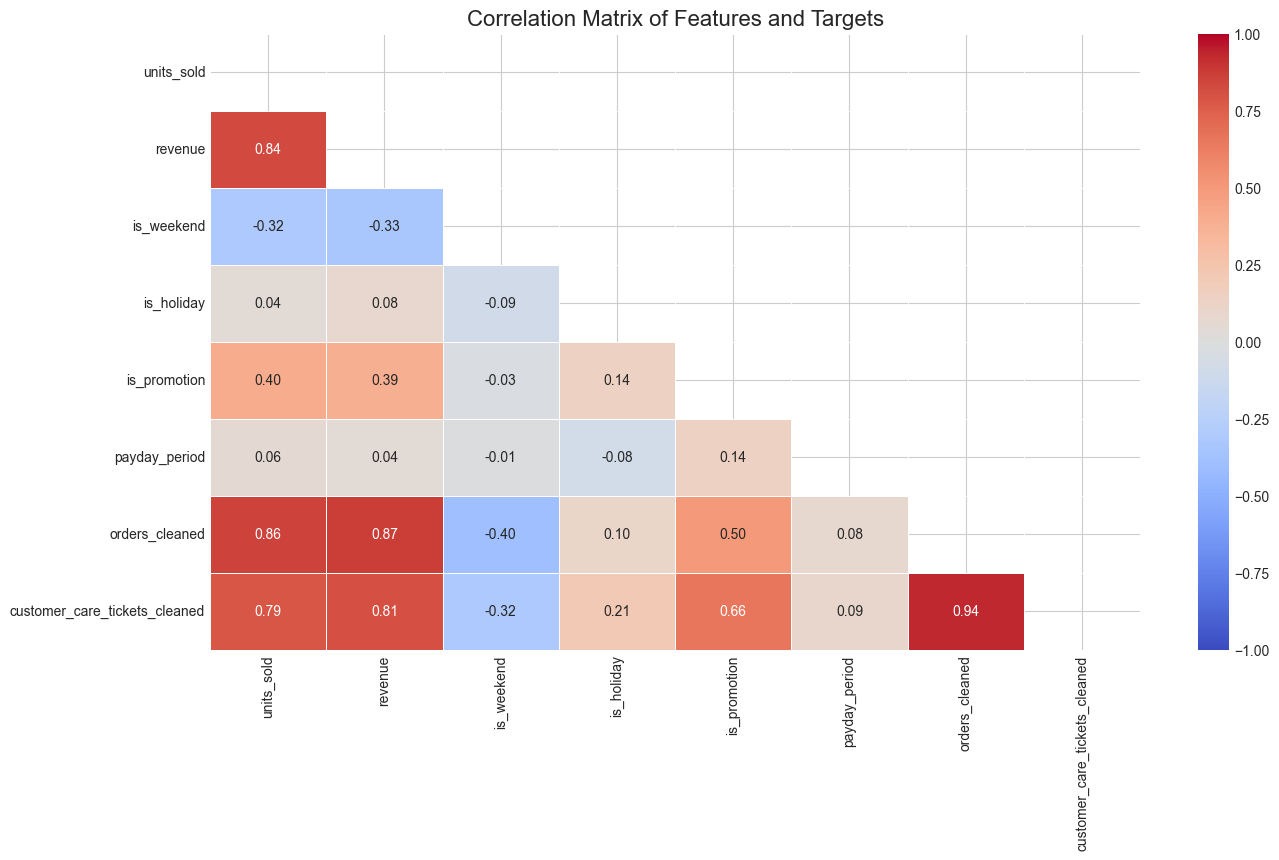

In [216]:
# Select Relevant Columns for the Correlation Matrix
cols_to_correlate = [
    'units_sold', 'revenue', 'is_weekend', 'is_holiday',
    'is_promotion', 'payday_period', 'orders_cleaned',
    'customer_care_tickets_cleaned'
]

# Compute the Correlation Matrix
corr_df = data_build1[cols_to_correlate]

# Compute the Correlation Matrix
corr_matrix = corr_df.corr()

# Plot the Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Create a mask to hide the upper triangle, which is a duplicate
plt.figure(figsize=(15, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',  # A diverging colormap is good for correlation
    annot=True,       # Write the data value in each cell
    fmt=".2f",        # Format annotations to two decimal places
    linewidths=.5,
    vmin=-1,
    vmax=1
)

plt.title('Correlation Matrix of Features and Targets', fontsize=16)
plt.show()

*Observations:*
- We have high correlation between orders vs. units sold and revenue (~ 0.86). 
- Though there is high correlation for units_sold, it's not close to being perfectly correlated, and it does provide some additional information. The deviation could be caused multiple items per order or data latency etc. It would be useful to create a lag feature for forecasting orders, to provide perspective on previous day activity.

### Create Relevant Feature

#### Clean-up unnecessary columns

#### Time Based Features

In [457]:
# Add in cols for date features
data_build1['day_of_week'] = data_build1['date'].dt.day_of_week 
data_build1['day_of_month'] = data_build1['date'].dt.day
data_build1['month'] = data_build1['date'].dt.month
data_build1['quarter'] = data_build1['date'].dt.quarter
data_build1['year'] = data_build1['date'].dt.year

data_build1.head()

,date,units_sold,revenue,is_weekend,is_holiday,is_promotion,payday_period,orders_cleaned,customer_care_tickets_cleaned,day_of_week,day_of_month,month,quarter,year
0,2023-01-01,1586,44791.35,1,1,0,0,613.0,78.0,6,1,1,1,2023
1,2023-01-02,1026,50143.22,0,0,0,0,598.0,49.0,0,2,1,1,2023
2,2023-01-03,1455,38737.17,0,0,0,0,522.0,61.0,1,3,1,1,2023
3,2023-01-04,1287,25786.90,0,0,0,0,519.0,54.0,2,4,1,1,2023
4,2023-01-05,1145,41630.79,0,0,0,0,609.0,54.0,3,5,1,1,2023


In [458]:
# data_build1['orders_cleaned_7_day_avg'] = data_build1['orders_cleaned'].shift(1).rolling(window=7).mean()
# data_build1['orders_cleaned_7_day_avg'] = data_build1['orders_cleaned_7_day_avg'].bfill() # Backfill initial NaNs
# data_build1['customer_tickets_7_day_avg'] = data_build1['customer_care_tickets_cleaned'].shift(1).rolling(window=7).mean()
# data_build1['orders_cleaned_14_day_avg'] = data_build1['orders_cleaned'].shift(1).rolling(window=14).mean()
# data_build1['customer_tickets_14_day_avg'] = data_build1['customer_care_tickets_cleaned'].shift(1).rolling(window=14).mean()
# data_build1['units_sold_7_day_avg'] = data_build1['units_sold'].shift(1).rolling(window=7).mean()
# data_build1['units_sold_7_day_avg'] = data_build1['units_sold_7_day_avg'].bfill() # Backfill initial NaNs

# data_build1['orders_lag_7'] = data_build1['orders_cleaned'].shift(7)
# data_build1['orders_lag_7'] = data_build1['orders_lag_7'].bfill()

data_build1.loc[5:10]

,date,units_sold,revenue,is_weekend,is_holiday,is_promotion,payday_period,orders_cleaned,customer_care_tickets_cleaned,day_of_week,day_of_month,month,quarter,year
5,2023-01-06,1515,25214.22,0,0,0,0,521.0,55.000,4,6,1,1,2023
6,2023-01-07,990,30817.58,1,0,0,0,399.0,33.000,5,7,1,1,2023
7,2023-01-08,854,18980.75,1,0,0,0,398.0,35.000,6,8,1,1,2023
8,2023-01-09,1280,43990.68,0,0,0,0,579.0,57.000,0,9,1,1,2023
9,2023-01-10,2929,156115.11,0,0,0,0,1682.5,181.875,1,10,1,1,2023
10,2023-01-11,1564,39018.76,0,0,0,0,586.0,53.000,2,11,1,1,2023


## Data Preparation 

### Data Transformation

In [459]:
sample = data_build1[['date','orders_cleaned','is_weekend','is_holiday','is_promotion','payday_period','day_of_week','day_of_month','month','quarter','year'
                    #   ,'units_sold_7_day_avg','orders_cleaned_7_day_avg'
                        # ,'orders_lag_7'
                      ]]
sample = sample.rename(columns= {'orders_cleaned':'y','date':'ds'}) 
sample['unique_id'] = 'order'
sample.tail()

,ds,y,is_weekend,is_holiday,is_promotion,payday_period,day_of_week,day_of_month,month,quarter,year,unique_id
725,2024-12-26,331.0,0,1,0,0,3,26,12,4,2024,order
726,2024-12-27,763.0,0,0,0,0,4,27,12,4,2024,order
727,2024-12-28,573.0,1,0,0,0,5,28,12,4,2024,order
728,2024-12-29,446.0,1,0,0,0,6,29,12,4,2024,order
729,2024-12-30,784.0,0,0,0,0,0,30,12,4,2024,order


### Set up Training & Testing Data

In [477]:
# Define horizon window
horizon_4wk = 28
horizon_6wk = 42
horizon_8wk = 56

# Define 4 week train-test split
test_4wk = sample.groupby(['unique_id']).tail(horizon_4wk)
train_4wk = sample.drop(test_4wk.index).reset_index(drop= True)

# Define 6 week train-test split
test_6wk = sample.groupby(['unique_id']).tail(horizon_6wk)
train_6wk = sample.drop(test_6wk.index).reset_index(drop= True)

# Define 8 week train-test split
test_8wk = sample.groupby(['unique_id']).tail(horizon_8wk)
train_8wk = sample.drop(test_8wk.index).reset_index(drop= True)

In [478]:
train_8wk.tail()

,ds,y,is_weekend,is_holiday,is_promotion,payday_period,day_of_week,day_of_month,month,quarter,year,unique_id
669,2024-10-31,1108.0,0,1,0,0,3,31,10,4,2024,order
670,2024-11-01,1682.5,0,0,0,0,4,1,11,4,2024,order
671,2024-11-02,521.0,1,0,0,0,5,2,11,4,2024,order
672,2024-11-03,501.0,1,0,0,0,6,3,11,4,2024,order
673,2024-11-04,879.0,0,0,0,0,0,4,11,4,2024,order


## Model Build 

In [480]:
futr_exog_sample_4wk = test_4wk.drop(['y'], axis= 1)
futr_exog_sample_6wk = test_6wk.drop(['y'], axis= 1)
futr_exog_sample_8wk = test_8wk.drop(['y'], axis= 1)

futr_exog_sample_8wk.head()

,ds,is_weekend,is_holiday,is_promotion,payday_period,day_of_week,day_of_month,month,quarter,year,unique_id
674,2024-11-05,0,0,0,0,1,5,11,4,2024,order
675,2024-11-06,0,0,0,0,2,6,11,4,2024,order
676,2024-11-07,0,0,0,0,3,7,11,4,2024,order
677,2024-11-08,0,0,0,0,4,8,11,4,2024,order
678,2024-11-09,1,0,0,0,5,9,11,4,2024,order


### Seasonal Naive (Baseline Forecast)

In [484]:
# Forecast model 4-wk
models = [
    SeasonalNaive(season_length= 7, alias= 'SeasonalNaive_exog_4')
]
sf = StatsForecast(models= models, freq= 'D')
sf.fit(df= train_4wk)

sn_exog_preds_4wk = sf.predict(h= horizon_4wk, X_df= futr_exog_sample_4wk, level= [85])

# Forecast model 6-wk
models = [
    SeasonalNaive(season_length= 7, alias= 'SeasonalNaive_exog_6')
]
sf = StatsForecast(models= models, freq= 'D')
sf.fit(df= train_6wk)

sn_exog_preds_6wk = sf.predict(h= horizon_6wk, X_df= futr_exog_sample_6wk, level= [85])

# Forecast model 8-wk
models = [
    SeasonalNaive(season_length= 7, alias= 'SeasonalNaive_exog_8')
]
sf = StatsForecast(models= models, freq= 'D')
sf.fit(df= train_8wk)

sn_exog_preds_8wk = sf.predict(h= horizon_8wk, X_df= futr_exog_sample_8wk, level= [85])


In [485]:
sn_exog_preds_8wk.head()

,unique_id,ds,SeasonalNaive_exog_8,SeasonalNaive_exog_8-lo-85,SeasonalNaive_exog_8-hi-85
0,order,2024-11-05,768.0,222.962957,1313.037043
1,order,2024-11-06,793.0,247.962957,1338.037043
2,order,2024-11-07,1108.0,562.962957,1653.037043
3,order,2024-11-08,1682.5,1137.462957,2227.537043
4,order,2024-11-09,521.0,-24.037043,1066.037043


### SARIMA(X)

In [486]:
# Forecast model 4-wk
models = [
    AutoARIMA(season_length= 7, alias= 'SARIMA_exog_4')
]

sf = StatsForecast(models= models, freq= 'D')
sf.fit(df= train_4wk)

arima_exog_preds_4wk = sf.predict(h= horizon_4wk, X_df= futr_exog_sample_4wk, level= [85])

# Forecast model 6-wk
models = [
    AutoARIMA(season_length= 7, alias= 'SARIMA_exog_6')
]

sf = StatsForecast(models= models, freq= 'D')
sf.fit(df= train_6wk)

arima_exog_preds_6wk = sf.predict(h= horizon_6wk, X_df= futr_exog_sample_6wk, level= [85])

# Forecast model 8-wk
models = [
    AutoARIMA(season_length= 7, alias= 'SARIMA_exog_8')
]

sf = StatsForecast(models= models, freq= 'D')
sf.fit(df= train_8wk)

arima_exog_preds_8wk = sf.predict(h= horizon_8wk, X_df= futr_exog_sample_8wk, level= [85])

In [487]:
arima_exog_preds_8wk.head()

,unique_id,ds,SARIMA_exog_8,SARIMA_exog_8-lo-85,SARIMA_exog_8-hi-85
0,order,2024-11-05,949.528474,600.791967,1298.264982
1,order,2024-11-06,948.063045,597.549278,1298.576812
2,order,2024-11-07,946.597616,594.315556,1298.879676
3,order,2024-11-08,945.132186,591.090665,1299.173708
4,order,2024-11-09,618.592730,262.800447,974.385013


#### Create Evaluation Table

In [593]:
test_df_4wk = test_4wk[['ds','y','unique_id']].merge(arima_exog_preds_4wk, on=['ds','unique_id'], how="left").merge(sn_exog_preds_4wk, on=['ds','unique_id'], how="left")
test_df_6wk = test_6wk[['ds','y','unique_id']].merge(arima_exog_preds_6wk, on=['ds','unique_id'], how="left").merge(sn_exog_preds_6wk, on=['ds','unique_id'], how="left")
test_df_8wk = test_8wk[['ds','y','unique_id']].merge(arima_exog_preds_8wk, on=['ds','unique_id'], how="left").merge(sn_exog_preds_8wk, on=['ds','unique_id'], how="left")
test_df_4wk.head()

,ds,y,unique_id,SARIMA_exog_4,SARIMA_exog_4-lo-85,SARIMA_exog_4-hi-85,SeasonalNaive_exog_4,SeasonalNaive_exog_4-lo-85,SeasonalNaive_exog_4-hi-85
0,2024-12-03,661.0,order,756.125102,407.518493,1104.731710,1377.0,826.65689,1927.34311
1,2024-12-04,641.0,order,755.336401,404.814317,1105.858484,1434.0,883.65689,1984.34311
2,2024-12-05,680.0,order,754.547699,402.120553,1106.974846,2081.0,1530.65689,2631.34311
3,2024-12-06,832.0,order,753.758998,399.437031,1108.080966,1929.0,1378.65689,2479.34311
4,2024-12-07,477.0,order,420.065616,63.858906,776.272325,897.0,346.65689,1447.34311


### Prophet

In [527]:
train_4wk.tail()

,ds,y,is_weekend,is_holiday,is_promotion,payday_period,day_of_week,day_of_month,month,quarter,year,unique_id
697,2024-11-28,2081.0,0,1,1,0,3,28,11,4,2024,order
698,2024-11-29,1929.0,0,1,1,0,4,29,11,4,2024,order
699,2024-11-30,897.0,1,0,1,0,5,30,11,4,2024,order
700,2024-12-01,877.0,1,0,1,0,6,1,12,4,2024,order
701,2024-12-02,1720.0,0,1,1,0,0,2,12,4,2024,order


In [528]:
# Forecast model 4-wk
m_4 = Prophet(
    changepoint_prior_scale= 0.5,
    changepoint_range= 0.8,
    seasonality_mode= 'multiplicative',
    seasonality_prior_scale= 10,
    interval_width=0.85 # Confidence Interval of 80%
)

m_4.add_regressor('is_weekend')
m_4.add_regressor('is_holiday')
m_4.add_regressor('is_promotion')
m_4.add_regressor('payday_period')
m_4.add_regressor('day_of_week')
m_4.add_regressor('day_of_month')
m_4.add_regressor('month')
m_4.add_regressor('quarter')
m_4.add_regressor('year')
# m.add_regressor('units_sold_7_day_avg')
# m.add_regressor('orders_cleaned_7_day_avg')
# m.add_regressor('orders_lag_7')

m_4.fit(train_4wk.drop(['unique_id'], axis=1))

# Forecast model 6-wk
m_6 = Prophet(
    changepoint_prior_scale= 0.5,
    changepoint_range= 0.8,
    seasonality_mode= 'multiplicative',
    seasonality_prior_scale= 10,
    interval_width=0.85 # Confidence Interval of 80%
)

m_6.add_regressor('is_weekend')
m_6.add_regressor('is_holiday')
m_6.add_regressor('is_promotion')
m_6.add_regressor('payday_period')
m_6.add_regressor('day_of_week')
m_6.add_regressor('day_of_month')
m_6.add_regressor('month')
m_6.add_regressor('quarter')
m_6.add_regressor('year')
# m.add_regressor('units_sold_7_day_avg')
# m.add_regressor('orders_cleaned_7_day_avg')
# m.add_regressor('orders_lag_7')

m_6.fit(train_6wk.drop(['unique_id'], axis=1))

# Forecast model 8-wk
m_8 = Prophet(
    changepoint_prior_scale= 0.5,
    changepoint_range= 0.8,
    seasonality_mode= 'multiplicative',
    seasonality_prior_scale= 10,
    interval_width=0.85 # Confidence Interval of 80%
)

m_8.add_regressor('is_weekend')
m_8.add_regressor('is_holiday')
m_8.add_regressor('is_promotion')
m_8.add_regressor('payday_period')
m_8.add_regressor('day_of_week')
m_8.add_regressor('day_of_month')
m_8.add_regressor('month')
m_8.add_regressor('quarter')
m_8.add_regressor('year')
# m.add_regressor('units_sold_7_day_avg')
# m.add_regressor('orders_cleaned_7_day_avg')
# m.add_regressor('orders_lag_7')

m_8.fit(train_8wk.drop(['unique_id'], axis=1))

15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
15:59:06 - cmdstanpy - INFO - Chain [1] start processing
15:59:06 - cmdstanpy - INFO - Chain [1] done processing


In [556]:
prophet_params = {
    'changepoint_prior_scale': 0.5,
    'changepoint_range': 0.8,
    'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 10,
    'interval_width': 0.85
}

regressors_to_add = [
    'is_weekend', 'is_holiday', 'is_promotion', 'payday_period',
    'day_of_week', 'day_of_month', 'month', 'quarter', 'year'
]

training_data = {
    '4': train_4wk,
    '6': train_6wk,
    '8': train_8wk
}

fitted_models = {}
for horizon, train_df in training_data.items():
    print(f"--- Fitting Prophet model for {horizon}-week horizon ---")
    
    # Initialize a new Prophet model with the defined parameters
    model = Prophet(**prophet_params)
    
    # Loop through the regressor list and add each one to the model
    for regressor in regressors_to_add:
        model.add_regressor(regressor)
        
    # Fit the model on the corresponding training data
    model.fit(train_df.drop(['unique_id'], axis=1))
    
    # Store the fully fitted model in our results dictionary
    fitted_models[f'm_{horizon}'] = model

print("\n--- Model fitting complete! ---")

m_4 = fitted_models['m_4']
m_6 = fitted_models['m_6']
m_8 = fitted_models['m_8']

print(f"Example: m_8 model has been fitted with {len(m_8.extra_regressors)} regressors.")

--- Fitting Prophet model for 4-week horizon ---


16:30:04 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing


--- Fitting Prophet model for 6-week horizon ---


16:30:04 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing


--- Fitting Prophet model for 8-week horizon ---


16:30:05 - cmdstanpy - INFO - Chain [1] start processing
16:30:05 - cmdstanpy - INFO - Chain [1] done processing



--- Model fitting complete! ---
Example: m_8 model has been fitted with 9 regressors.


In [557]:
future_4wk = m_4.make_future_dataframe(periods= 28)
future_6wk = m_6.make_future_dataframe(periods= 42)
future_8wk = m_8.make_future_dataframe(periods= 56)
future_8wk.head()

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05


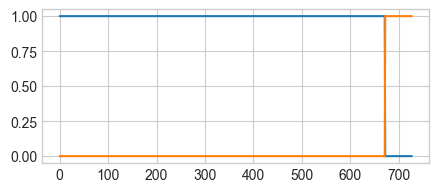

In [558]:
# Create a train and forecast index for the future dataframe

train_index_8wk = future_8wk['ds'].isin(train_8wk['ds'])
forecast_index_8wk = ~train_index_8wk

# plot the train index and test index to see the split
plt.figure(figsize= (5,2))
plt.plot(train_index_8wk)
plt.plot(forecast_index_8wk)
plt.show()

In [559]:
regressor_cols = [
    'ds', 'is_weekend', 'is_holiday', 'is_promotion', 'payday_period',
    'day_of_week', 'day_of_month', 'month', 'quarter', 'year'
]

future_dfs = {
    '4wk': future_4wk,
    '6wk': future_6wk,
    '8wk': future_8wk
}

merged_dfs = {}

for horizon, future_df in future_dfs.items():
    print(f"Merging regressors for {horizon} horizon...")
    merged_dfs[horizon] = pd.merge(
        future_df,
        sample[regressor_cols],
        on='ds',
        how='left'
    )

future_with_regressors_4wk = merged_dfs['4wk']
future_with_regressors_6wk = merged_dfs['6wk']
future_with_regressors_8wk = merged_dfs['8wk']

print("\n--- Head of the 4-week merged DataFrame ---")
future_with_regressors_4wk.head()

Merging regressors for 4wk horizon...
Merging regressors for 6wk horizon...
Merging regressors for 8wk horizon...

--- Head of the 4-week merged DataFrame ---


,ds,is_weekend,is_holiday,is_promotion,payday_period,day_of_week,day_of_month,month,quarter,year
0,2023-01-01,1,1,0,0,6,1,1,1,2023
1,2023-01-02,0,0,0,0,0,2,1,1,2023
2,2023-01-03,0,0,0,0,1,3,1,1,2023
3,2023-01-04,0,0,0,0,2,4,1,1,2023
4,2023-01-05,0,0,0,0,3,5,1,1,2023


--- Generating plots for 4-week horizon ---


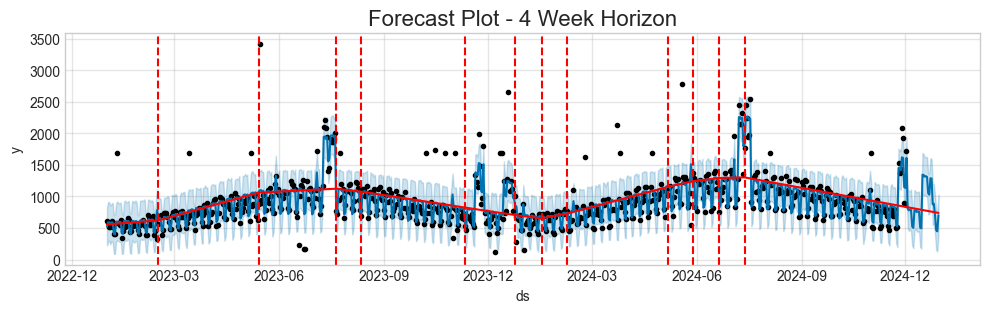

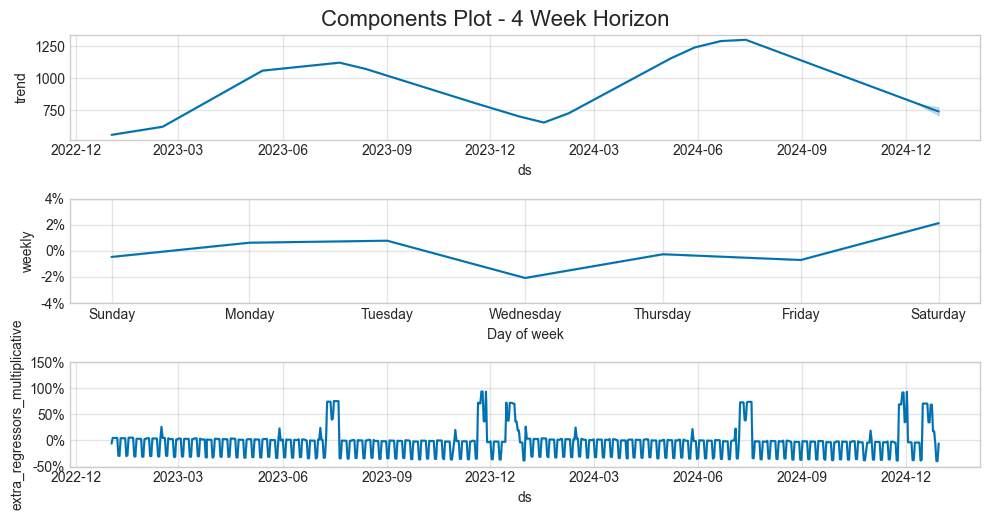

--- Generating plots for 6-week horizon ---


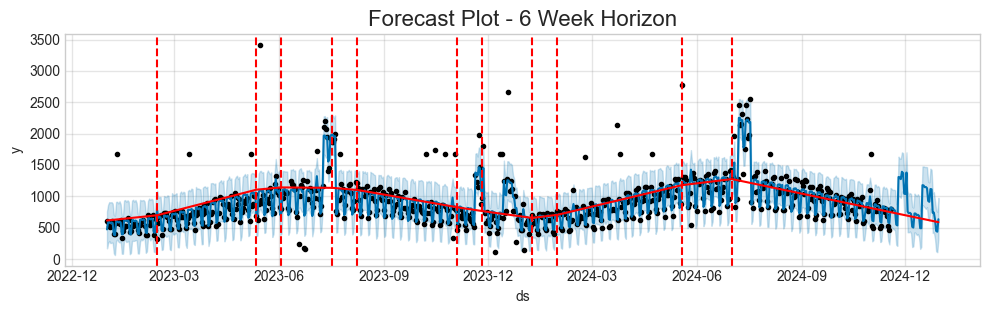

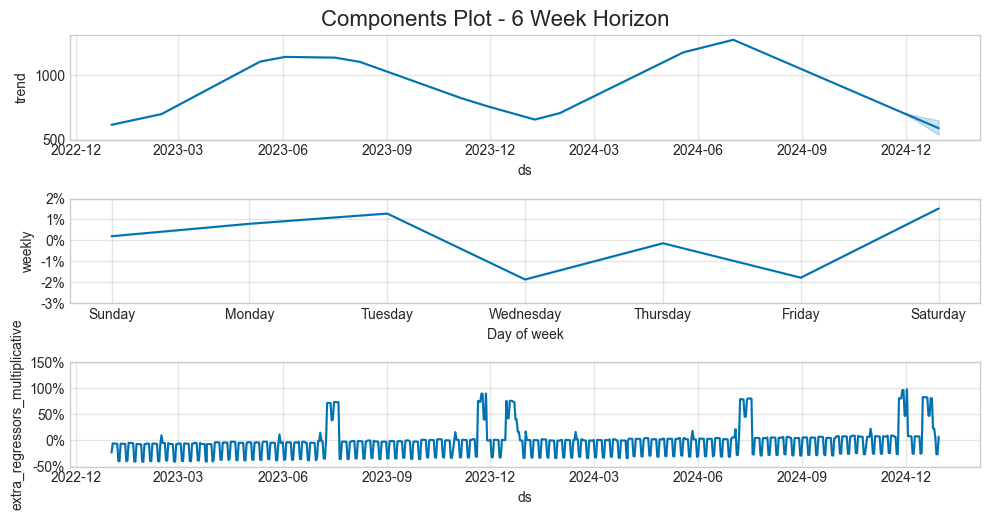

--- Generating plots for 8-week horizon ---


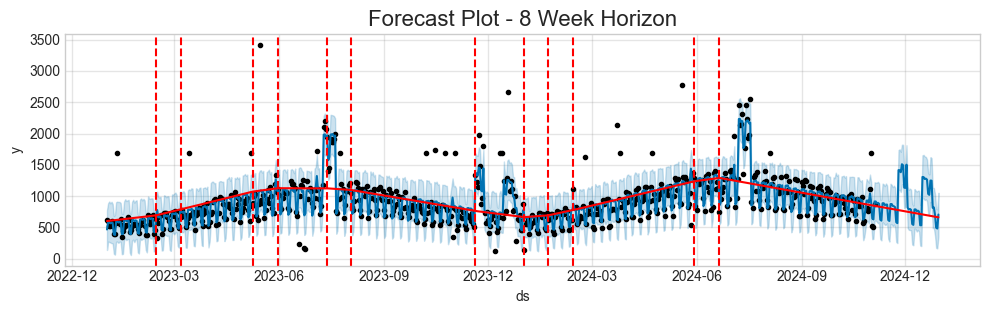

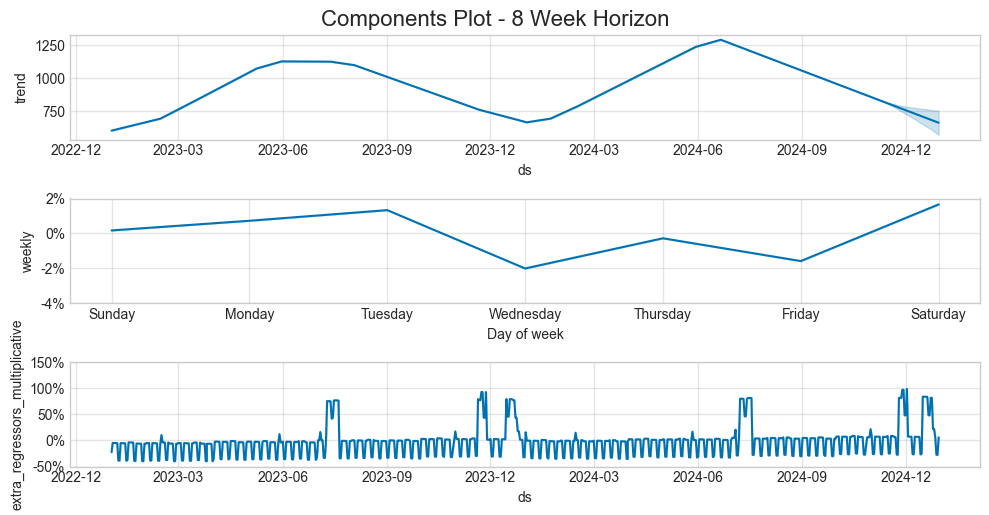


--- Plotting complete! ---


In [605]:
fitted_models = {
    '4': m_4,
    '6': m_6,
    '8': m_8
}

future_dfs = {
    '4': future_with_regressors_4wk,
    '6': future_with_regressors_6wk,
    '8': future_with_regressors_8wk
}

for horizon in ['4', '6', '8']:
    print(f"--- Generating plots for {horizon}-week horizon ---")

    model = fitted_models[horizon]
    future_df = future_dfs[horizon]

    forecast = model.predict(future_df)

    fig1 = model.plot(forecast, figsize=(10, 3))
    add_changepoints_to_plot(fig1.gca(), model, forecast)
    plt.title(f'Forecast Plot - {horizon} Week Horizon', fontsize=16)
    plt.show() 

    fig2 = model.plot_components(forecast, figsize=(10, 5))
    plt.suptitle(f'Components Plot - {horizon} Week Horizon', y=1.02, fontsize=16)
    plt.show() 

print("\n--- Plotting complete! ---")

In [594]:
test_df_4wk = test_df_4wk.merge(forecast_4wk[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on= 'ds', how= 'left')
test_df_4wk = test_df_4wk.rename(columns= {'yhat':'Prophet_4','yhat_lower':'Prophet_4-lo-85','yhat_upper':'Prophet_4-hi-85'})

In [595]:
test_df_6wk = test_df_6wk.merge(forecast_6wk[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on= 'ds', how= 'left')
test_df_6wk = test_df_6wk.rename(columns= {'yhat':'Prophet_6','yhat_lower':'Prophet_6-lo-85','yhat_upper':'Prophet_6-hi-85'})

In [596]:
test_df_8wk = test_df_8wk.merge(forecast_8wk[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on= 'ds', how= 'left')
test_df_8wk = test_df_8wk.rename(columns= {'yhat':'Prophet_8','yhat_lower':'Prophet_8-lo-85','yhat_upper':'Prophet_8-hi-85'})

In [597]:
test_df_8wk.head()

,ds,y,unique_id,SARIMA_exog_8,SARIMA_exog_8-lo-85,SARIMA_exog_8-hi-85,SeasonalNaive_exog_8,SeasonalNaive_exog_8-lo-85,SeasonalNaive_exog_8-hi-85,Prophet_8,Prophet_8-lo-85,Prophet_8-hi-85
0,2024-11-05,767.0,order,949.528474,600.791967,1298.264982,768.0,222.962957,1313.037043,915.505379,587.588834,1225.341026
1,2024-11-06,937.0,order,948.063045,597.549278,1298.576812,793.0,247.962957,1338.037043,883.067644,537.425984,1185.346121
2,2024-11-07,848.0,order,946.597616,594.315556,1298.879676,1108.0,562.962957,1653.037043,893.307776,572.187337,1187.023634
3,2024-11-08,764.0,order,945.132186,591.090665,1299.173708,1682.5,1137.462957,2227.537043,878.131462,543.991916,1182.600334
4,2024-11-09,502.0,order,618.592730,262.800447,974.385013,521.0,-24.037043,1066.037043,624.747813,316.475083,949.071387


## Model Evaluation

### Plot forecast

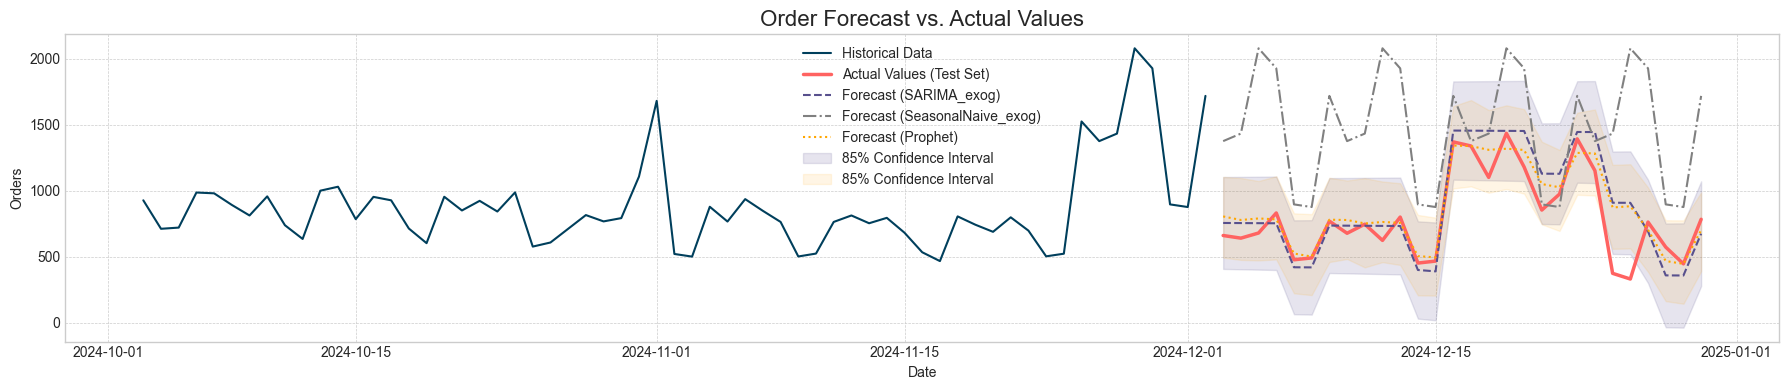

In [572]:
# Set up the figure and axes
plt.figure(figsize=(18, 4))

# Plot historical data (from the training set)
sns.lineplot(data=train_4wk.tail(60), x='ds', y='y', label='Historical Data', color='#003f5c')

# Plot actual future data (from the test set)
sns.lineplot(data=test_df_4wk, x='ds', y='y', label='Actual Values (Test Set)', color='#ff6361', linewidth=2.5)

# Plot the SARIMA forecast
sns.lineplot(data=test_df_4wk, x='ds', y='SARIMA_exog_4', label='Forecast (SARIMA_exog)', color='#58508d', linestyle='--')

# Plot the Seasonal Naive forecast
sns.lineplot(data=test_df_4wk, x='ds', y='SeasonalNaive_exog_4', label='Forecast (SeasonalNaive_exog)', color='grey', linestyle='-.')

# Plot the Prophet forecast
sns.lineplot(data=test_df_4wk, x='ds', y='Prophet_4', label='Forecast (Prophet)', color='#ffa600', linestyle=':')

# Add the SARIMA confidence interval
plt.fill_between(
    x=test_df_4wk['ds'],
    y1=test_df_4wk['SARIMA_exog_4-lo-85'],
    y2=test_df_4wk['SARIMA_exog_4-hi-85'],
    alpha=0.15,
    color='#58508d',
    label= '85% Confidence Interval'
)

# Add the Prophet confidence interval
plt.fill_between(
    x=test_df_4wk['ds'],
    y1=test_df_4wk['Prophet_4-lo-85'],
    y2=test_df_4wk['Prophet_4-hi-85'],
    alpha=0.1,
    color='#ffa600',
    label= '85% Confidence Interval'
)

# --- 3. Customize and Show the Plot ---
plt.title('Order Forecast vs. Actual Values', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Evaluate Metrics

In [585]:
test_df_8wk.head()

,ds,y,unique_id,SARIMA_exog_8,SARIMA_exog_8-lo-85,SARIMA_exog_8-hi-85,SeasonalNaive_exog_8,SeasonalNaive_exog_8-lo-85,SeasonalNaive_exog_8-hi-85,Prophet_8,Prophet_8-lo-85,Prophet_8-hi-85
0,2024-11-05,767.0,order,949.528474,600.791967,1298.264982,768.0,222.962957,1313.037043,915.505379,587.588834,1225.341026
1,2024-11-06,937.0,order,948.063045,597.549278,1298.576812,793.0,247.962957,1338.037043,883.067644,537.425984,1185.346121
2,2024-11-07,848.0,order,946.597616,594.315556,1298.879676,1108.0,562.962957,1653.037043,893.307776,572.187337,1187.023634
3,2024-11-08,764.0,order,945.132186,591.090665,1299.173708,1682.5,1137.462957,2227.537043,878.131462,543.991916,1182.600334
4,2024-11-09,502.0,order,618.592730,262.800447,974.385013,521.0,-24.037043,1066.037043,624.747813,316.475083,949.071387


In [602]:
# Derive Evaluation metrics for 4,6 and 8 week forecasts
training_data = {'4': train_4wk, '6': train_6wk, '8': train_8wk}
testing_data = {'4': test_df_4wk, '6': test_df_6wk, '8': test_df_8wk}

metrics = [
    mae, mse, rmse, mape, smape,
    partial(mase, seasonality=7),
    scaled_crps
]

evaluation_results = {}

for horizon in ['4', '6', '8']:
    print(f"--- Evaluating models for {horizon}-week horizon ---")

    models = [f'SARIMA_exog_{horizon}',
              f'SeasonalNaive_exog_{horizon}',
              f'Prophet_{horizon}']

    eval_table = evaluate(
        testing_data[horizon].drop(['ds'], axis=1),
        metrics=metrics,
        models=models,
        train_df=training_data[horizon],
        level=[85]
    )

    processed_table = eval_table.drop(['unique_id'], axis=1).groupby(['metric']).mean().reset_index()
    evaluation_results[f'final_eval_{horizon}wk'] = processed_table

print("\n--- Evaluation complete! ---")

final_eval_4wk = evaluation_results['final_eval_4wk']
final_eval_6wk = evaluation_results['final_eval_6wk']
final_eval_8wk = evaluation_results['final_eval_8wk']

final_eval = final_eval_4wk.merge(final_eval_6wk, on= 'metric').merge(final_eval_8wk, on= 'metric')

print("\n--- Final Evaluation Table Output:---")
final_eval.head()


--- Evaluating models for 4-week horizon ---
--- Evaluating models for 6-week horizon ---
--- Evaluating models for 8-week horizon ---

--- Evaluation complete! ---

--- Final Evaluation Table Output:---


,metric,SARIMA_exog_4,SeasonalNaive_exog_4,Prophet_4,SARIMA_exog_6,SeasonalNaive_exog_6,Prophet_6,SARIMA_exog_8,SeasonalNaive_exog_8,Prophet_8
0,mae,147.186236,680.642857,112.428652,160.179588,307.857143,139.250057,212.073278,333.964286,127.757495
1,mape,0.248190,1.099140,0.201617,0.218264,0.296710,0.164490,0.292966,0.397574,0.179311
2,mase,0.704677,3.258683,0.538270,0.782687,1.504285,0.680419,1.029546,1.621286,0.620220
3,mse,41887.937186,655244.857143,29017.893997,50076.557015,199286.428571,40656.191287,69020.978299,209373.553571,29161.866870
4,rmse,204.665427,809.471962,170.346394,223.777919,446.415086,201.633805,262.718439,457.573550,170.768460


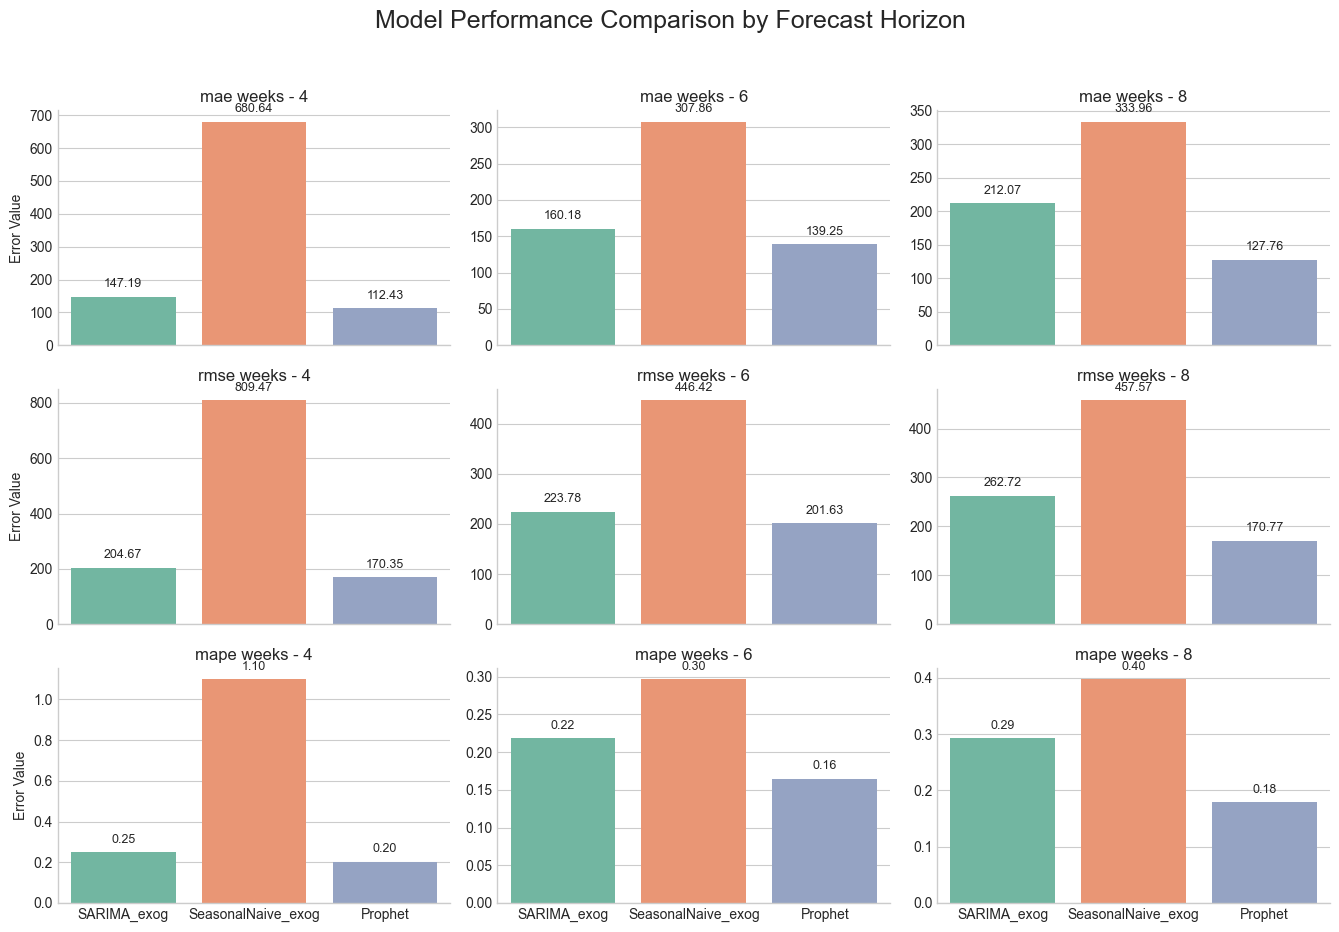

In [601]:
# Prepare the Data for Plotting
eval_df = pd.DataFrame(final_eval).set_index('metric')

# Reshape the Data for Plotting
# Keep only the metrics we need
plot_df = eval_df.loc[['mae', 'rmse', 'mape']]

# Transpose and reset index to turn model/horizon into a column
plot_df = plot_df.T.reset_index()
plot_df.rename(columns={'index': 'Model_Horizon'}, inplace=True)

# Split 'Model_Horizon' into 'Model' and 'Horizon' columns
plot_df[['Model', 'Horizon']] = plot_df['Model_Horizon'].str.rsplit('_', n=1, expand=True)

# Melt the DataFrame to get a "long" format
melted_df = plot_df.melt(
    id_vars=['Model', 'Horizon'],
    value_vars=['mae', 'rmse', 'mape'],
    var_name='Metric',
    value_name='Value'
)

# Create the Faceted Plot using catplot 
g = sns.catplot(
    data=melted_df,
    x='Model',          
    y='Value',          
    col='Horizon',      
    row='Metric',       
    kind='bar',         
    sharey=False,       
    palette='Set2',
    height=3,           
    aspect=1.5          
)

# Customize Titles and Add Data Labels 
g.fig.suptitle('Model Performance Comparison by Forecast Horizon', y=1.03, fontsize=18)

# Iterate through each subplot (Axes) to add labels
for ax in g.axes.flat:
    # Set titles for each subplot from the automatic row/col titles
    title = ax.get_title()
    ax.set_title(title.replace('Metric = ', '').replace(' | Horizon = ', ' weeks - '))
    
    # Add data labels to each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)
    ax.set_xlabel('') 

g.set_ylabels('Error Value')
plt.tight_layout()
plt.show()